In [38]:
import numpy as np
from sympy.utilities.iterables import multiset_permutations
import matplotlib.pyplot as plt
from tqdm import tqdm

In [138]:
Ns = 8 # number of single-particle states
Ns = 2 * Ns # adjust for spin
Np = 8 #number of fermionic particles #N0 = Ns/2 N = Np
n = 2*Np/(Ns) # filling factor
print(n)

1.0


In [139]:
def q(N1, k):
    return np.sum(N1[:k])
def one_el(N1,N2,r,s):
    N1_1 = np.delete(N1, np.array([r,s]))
    N2_1 = np.delete(N2, np.array([r,s]))
    delta = np.all(N1_1 == N2_1)
    dr = 0
    ds = 0
    if r != s:
        if N1[r]-1 == N2[r] :
            dr = 1
        if N1[s] == N2[s]-1 :
            ds = 1
    if r == s:
        if N1[r] == N2[s]:
            dr = 1
            ds = 1
    return (N1[r]*((-1)**q(N1,r)))*(N2[s]*((-1)**q(N2,s)))*delta*dr*ds
def two_el(N1, N2, r, s, t, v):
    sig_v = N2[v]*(-1)**q(N2,v)
    N2[v]-=1
    if sig_v != 0:
        sig_t = N2[t]*(-1)**q(N2,t) * sig_v
        N2[t]-=1
        if sig_t != 0:
            sig_s = (1-N2[s])*(-1)**q(N2,s) * sig_t
            N2[s] += 1
            if sig_s != 0:
                sig_r = (1-N2[r])*(-1)**q(N2,r) * sig_s
                N2[r] += 1
                if sig_r != 0 and np.all(N1 == N2):
                    return sig_r
    return 0

def spin(ind):
    if ind < Ns/2:
        return 1
    if ind >= Ns/2:
        return 0
def site(ind):
    if ind < Ns/2:
        return ind
    if ind >= Ns/2:
        return int(ind - Ns/2)
spin_vec = np.vectorize(spin)
site_vec = np.vectorize(site)
print(spin_vec(np.arange(Ns)))
print(site_vec(np.arange(Ns)))

[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
[0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7]


In [171]:
V = 1;
def hub_U(r,s,t,v): # spin off-diagonal, site-diagonal
    sites = site_vec(np.array([r,s,t,v]))
    if len(np.unique(sites)) != 1:
        return 0
    else:
        if spin(r) == spin(t) and spin(s) == spin(v) and spin(r) != spin(s):
            return V/2
        else:
            return V/4
def nearest(site1,site2):
    if site1 == site2 + 1:
        return 1
    if site1 == site2 - 1:
        return 1
    if site2 == site1 + 1:
        return 1
    if site2 == site1 - 1:
        return 1
    if site2 + Ns/2 == site1 + 1:
        return 1
    if site1 + Ns/2 == site2 + 1:
        return 1
    return 0
def next_nearest(site1, site2):
    if nearest(site1,site2):
        return 1
    if site1 == site2 + 2:
        return 1
    if site1 == site2 - 2:
        return 1
    if site2 == site1 + 2:
        return 1
    if site2 == site1 - 2:
        return 1
    if site2 + Ns/2 == site1 + 2:
        return 1
    if site1 + Ns/2 == site2 + 2:
        return 1
    return 0
def hub_U2(r,s,t,v): # spin off-diagonal site nearest neighbors
    sites = site_vec(np.array([r,s,t,v]))
    spins = spin_vec(np.array([r,s,t,v]))
    if sites[0] == sites[2] and spins[0] == spins[2]:
        if sites[1] == sites[3] and spins[1] == spins[3]:
            if spins[0] != spins[1]:
                if sites[0]==sites[1]:
                    return V/2
                if next_nearest(sites[0],sites[1])==1:
                    return V/6
    return 0# V/3
    
t = 1;
def NN(r,s): 
    if spin(r) == spin(s):
        return -1*nearest(site(r), site(s))*t
    return 0

def one_el_mat(op):
    out_mat = np.zeros((Ns, Ns), dtype=complex)
    for r in range(Ns):
        for s in range(Ns):
            out_mat[r,s] = op(r,s)
    return out_mat
def two_el_mat(op):
    out_mat = np.zeros((Ns, Ns, Ns, Ns), dtype=complex)
    for r in range(Ns):
        for s in range(Ns):
            for t in range(Ns):
                for v in range(Ns):
                    out_mat[r,s,t,v] = op(r,s,t,v)
    return out_mat
    
NN_mat = one_el_mat(NN)
U_mat = two_el_mat(hub_U)

In [172]:
def S(Np, Ns):
    S0 = np.zeros(Ns,dtype=int)
    S0[:Np] = 1
    return np.array(list(multiset_permutations(S0)))
N1_basis = S(1,Ns)
#N2_basis = S(2,Ns)
print(len(N1_basis))

16


In [173]:
def one_el_op(op_mat,basis):
    one_el_mat = np.zeros((len(basis),len(basis)),dtype=complex)
    op_mat_pos = np.where(op_mat != 0.0)
    ran = np.arange(len(basis))
    for n in tqdm(range(len(basis))):
        for m in ran[n:]:
            for pos_n in range(len(op_mat_pos[1])):
                r = op_mat_pos[0][pos_n]
                s = op_mat_pos[1][pos_n]
                one_el_mat[n,m] += one_el(basis[n],basis[m],r,s)*op_mat[r,s]
            one_el_mat[m,n] = np.conjugate(one_el_mat[n,m])
    return one_el_mat

NN_CI_N1_mat = one_el_op(NN_mat,N1_basis)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 90.87it/s]


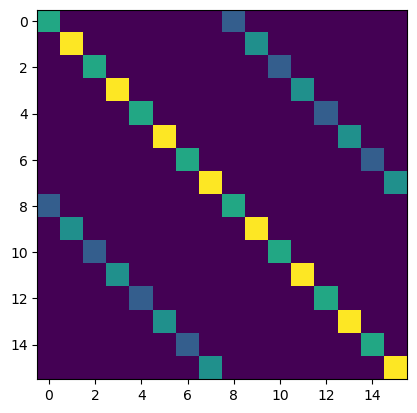

In [174]:

def one_el_mf(op_mat,U_ref):
    out = np.zeros((Ns, Ns), dtype=complex)
    for r in range(Ns):
        for s in range(Ns):
            for t in range(Ns):
                for u in range(Ns):
                    for m in range(Np):
                        out[r,s] += (2*op_mat[r,t,s,u] - op_mat[r,t,u,s])*np.dot(np.conjugate(U_ref[t,m]),U_ref[u,m])
    return out

def get_MF(U_mat, U_ref):
    umat_one_el_mf = one_el_mf(U_mat, U_ref)
    #U_CI_MF_mat = one_el_op(umat_one_el_mf, N1_basis)
    return umat_one_el_mf
e0,U = np.linalg.eigh(NN_CI_N1_mat)
plt.imshow(np.abs(get_MF(U_mat,U[:,:Np])))
plt.show()


In [181]:
def get_diff(U0,U1):
    dif1 = np.zeros((Ns, Ns),dtype=complex)
    dif2 = np.zeros((Ns, Ns),dtype=complex)
    for r in range(Ns):
        for s in range(Ns):
            dif1[r,s] = np.sum(np.conjugate(U1[r,:])*U1[s,:])
            dif2[r,s] = np.sum(np.conjugate(U0[r,:])*U0[s,:])
    #print(dif1)
    #print(dif2)
    return np.sum(np.abs(dif1 - dif2))

def HF():
    diff = 1
    e,U = np.linalg.eigh(NN_CI_N1_mat)
    U0 = U
    n=1
    max_iter = 10000
    for n in range(max_iter):
        U_ref = U[:,:Np]
        U_last = U
        e_last = e
        U_1el = get_MF(U_mat,U_ref)
        e,U = np.linalg.eigh(NN_CI_N1_mat + U_1el)
        
        #plt.imshow(np.abs(U))
        #plt.show()
        #plt.imshow(np.abs(U_last))
        #plt.show()
        diff = get_diff(U,U_last)#
        print(np.sum(e))
        print(n,diff)
        if diff < 1e-10:
            break
        #break
    print('number of iterations: ',n)
    return U0,U, e
U,U_MF,e=HF()
print(np.sum(e))
print(2*np.sum(e0+((V*n)/4)))

7.999999999999997
0 6.847994393766044e-14
number of iterations:  0
7.999999999999997
8.0


In [179]:
e,U = np.linalg.eigh(NN_CI_N1_mat)
print(U[:,0])
print(U[:,1])

[-0.35355339+0.j -0.35355339+0.j -0.35355339+0.j -0.35355339+0.j
 -0.35355339+0.j -0.35355339+0.j -0.35355339+0.j -0.35355339+0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
[ 0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
 -0.35355339+0.j -0.35355339+0.j -0.35355339+0.j -0.35355339+0.j
 -0.35355339+0.j -0.35355339+0.j -0.35355339+0.j -0.35355339+0.j]
